In [1]:
import gdown, IPython 
gdown.download('https://drive.google.com/file/d/13gFx0pIMLdcAp2Rc3wDcITFSCwxL8I4D/view?usp=share_link', 'decorated_header.html', quiet=True, fuzzy=True)
IPython.display.HTML(filename="decorated_header.html") # the author of the style: https://codepen.io/juanbrujo/pen/DBKxxM

### **Dane geograficzne regionów na mapie Europy**

> <p><span style="font-family:Times New Roman,Times,serif"><strong>Eurostat</strong>, GISKO (NUTS 0), main EU regions:<br />
<a href="https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts" rel="nofollow" target="_blank"><span style="color:#2980b9">https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts</span></a></span></p>

<p><span style="font-family:Times New Roman,Times,serif"><span style="color:#2980b9"><img alt="" src="https://ec.europa.eu/eurostat/documents/7116161/7117206/NUTS-layers.gif" width=400/></span></span></p>

---



In [2]:
# Instalacja potrzebnych bibliotek
!pip -q install geopandas           # rysowanie punktów na mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.3 MB/s eta 0:00:00


In [3]:
# Import potrzebnych bibliotek
import gdown                        # pobieranie plików z Google Dysku
import geopandas as gpd             # do rysowania punktów na mapie oraz odczytu danych

In [4]:
# Usuwamy przykładowe dane dostępne domyślnie na maszynie wirtualnej Google:
!rm -fr sample_data

# Pobieramy przygotowane dane i zapisujemy je na maszynie wirtualnej w postaci pliku json:
polygons_url = 'https://drive.google.com/file/d/1QYPzX9vBs2E-DFi44Ry4Ed-vjbcJtNQH/view?usp=share_link'
polygons_file = 'NUTS_RG_01M_2021_3035_LEVL_0.json'
gdown.download(polygons_url, polygons_file, quiet=True, fuzzy=True)

'NUTS_RG_01M_2021_3035_LEVL_0.json'

In [7]:
# Odczyt danych/współrzędnych geograficznych punktów z pobranego pliku (polygons)
regions = gpd.read_file(polygons_file)
# Tworzenie w strukturze danych kolumn, w których zamieścimy liczby określające wiek
regions = regions.assign(male_age=0)
regions = regions.assign(female_age=0)

### **Pobranie kodów krajów, mapowanie na nazwy**

> <p><span style="font-family:Times New Roman,Times,serif"><strong>Eurostat</strong>, Country codes:<br />
<a href="https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Country_codes" rel="nofollow"><span style="color:#2980b9;">https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Country_codes</span></a></span></p>

---



In [8]:
# Import bibliotek (w tym BeautifulSoup w celu uzyskania elementów wprost z dokumentu html)
from bs4 import BeautifulSoup as BS
from urllib.request import urlopen

# Pobieranie danych ze strony: nazw oraz kodów krajów
html = urlopen("https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Country_codes")
soup = BS(html)

countries_and_code = soup.find_all('td')
countries_raw = []
codes_raw = []

for i in range(54):
  if i % 2 == 0:
    countries_raw.append(countries_and_code[i].text)
  else:
    codes_raw.append(countries_and_code[i].text)

# Usunięcie zbędnych znaczników
countries = [item.replace('(','').replace(')','').replace('\n','') for item in countries_raw]
codes = [item.replace('(','').replace(')','').replace('\n','') for item in codes_raw]

### **Pobranie właściwych danych (długość życia, 2022 rok)**

> <p><span style="font-family:Times New Roman,Times,serif"><strong>UNICEF Data Warehouse</strong>, Country codes:<br />
<a href="https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Country_codes" rel="nofollow"><span style="color:#2980b9;">https://data.unicef.org/resources/data_explorer/unicef_f/?ag=UNICEF&df=GLOBAL_DATAFLOW&ver=1.0&dq=.DM_LIFE_EXP..&startPeriod=2013&endPeriod=2022</span></a></span></p>


---




In [9]:
# Import biblioteki potrzebnej do przetworzenia danych z pliku formatu CSV
import csv

# Pobranie danych z pliku CSV zlokalizowanym przez z nas na Google Dysku
data_url = 'https://drive.google.com/file/d/1WURKArd7Fp4sUf71ftCrMf7gG02XL76X/view?usp=sharing'
data_file = 'prepared_data.csv'
gdown.download(data_url, data_file, quiet=True, fuzzy=True)

# Ładowanie pobranych danych do list
countries_from_data, males, females, total = [[] for i in range(4)]

with open(data_file, 'r') as data_csv_file:
    reader = csv.DictReader(data_csv_file, ["country", "category", "value"], delimiter=';')

    for row in reader:
      countries_from_data.append(row["country"])
      value = row["value"]

      match row["category"]:
        case "Male":
          males.append(value)
        case "Female":
          females.append(value)
        case "Total":
          total.append(value)

# Usunięcie powtarzających się wpisów
del countries_from_data[::3]
del countries_from_data[::2]

In [10]:
# Mapowanie nazw krajów na kody poprzez tworzenie słownika i kilku krotek
dictionary = dict(zip(countries, codes))
males_by_country = dict(zip(countries_from_data, males))
females_by_country = dict(zip(countries_from_data, females))

males_by_code = {}
females_by_code = {}

for country, value in males_by_country.items():
    code = dictionary[country]
    males_by_code[code] = value

for country, value in females_by_country.items():
    code = dictionary[country]
    females_by_code[code] = value

### **Wstawienie danych do struktury GeoDataFrame** 
> Przyporządkowanie badanych danych do poszczególnych regionów

---


In [11]:
# Iterowanie po wszystkich wpisach w strukturze GeoDataFrame
for index, row in regions.iterrows():
    # Sprawdzenie za pomocą kodu kraju, czy mamy do niego odpowiednie dane
    if row['CNTR_CODE'] in males_by_code:
        # Aktualizacja kolumny określającej długość życia mężczyzn
        regions.loc[index, 'male_age'] = males_by_code[row['CNTR_CODE']]
    else:
        # Ustawenie wartości kolumny na 0 w przypadku braku danych
        regions.loc[index, 'male_age'] = float('NaN')
    
    if row['CNTR_CODE'] in females_by_code:
        # Aktualizacja kolumny określającej długość życia kobiet
        regions.loc[index, 'female_age'] = females_by_code[row['CNTR_CODE']]
    else:
        # Ustawenie wartości kolumny na 0 w przypadku braku danych
        regions.loc[index, 'female_age'] = float('NaN')

# Konwertacja zapisanych wartości do typu liczb zmiennoprzecinkowych
regions['male_age'] = regions['male_age'].astype(float)
regions['female_age'] = regions['female_age'].astype(float)

# print(regions.head())    # ---> Odkomentuj, żeby zobaczyć, jak wygląda struktura

### **Rysowanie wykresów**
> Kolor regionów na mapie zależy od wybranej ze struktury danych kolumny głównej <br>
(w tym przypadku: długość życia = średnia wartość wieku)

---


In [12]:
# Import bibliotek potrzebnych do rysowania
import matplotlib.pyplot as plt                           # zmiana stylów wykresu 
from mpl_toolkits.axes_grid1 import make_axes_locatable   # zmiana osi, legendy
import matplotlib.patheffects as path_effects             # do obramowania tekstu

# Odwrotne mapowanie (kod -> nazwa kraju)
def get_key_by_value(my_dict, value):
    for key, val in my_dict.items():
        if val == value:
            return key
    return None

# Główna funkcja rysująca mapę
def plot_the_map(gender, colour_map):
  """Funkcja rysująca wykresy (mapy). Jako argumenty przyjmuje wybrany temat koloru oraz
  płeć (na podstawie tego będzie wiadomo, którą kolumnę ustawić jako główną)"""
  fig, ax = plt.subplots(figsize=(10,10))
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("bottom", size="2%", pad=0.3)

  gender_pl = "mężczyźni" if gender == 'male' else "kobiety" if gender == 'female' else "-" 
  title = "Oczekiwana dalsza długość\ntrwania życia (" + gender_pl + ", 2022)" 
  fig.suptitle(title, fontsize=13, y=0.85, x=0.15, ha='left', family='serif')

  fig = ax.figure
  cb_ax = fig.axes[1] 
  cb_ax.tick_params(labelsize=10)

  primary_column = gender + '_age'

  regions.plot(
      column=primary_column, 
      ax=ax, 
      legend=True, 
      cax=cax, 
      cmap=colour_map, 
      legend_kwds={'label': 'Wiek', 'orientation': 'horizontal'},
      missing_kwds=dict(color = "white"),
      edgecolor='white',
      linewidth=0.1
  )

  ax.set_xlim(xmin=2.2e6, xmax=6.8e6)
  ax.set_ylim(ymin=1e6, ymax=5.4e6)

  # Usunięcie oznaczeń osi (żeby mieć tylko legendę i sam wykres)
  ax.set(xticklabels=[])
  ax.set(yticklabels=[])
  ax.tick_params(axis='both', which='both', length=0)

  # Nie chcemy wyświetlać kodów krajów, które nie należą do UE 
  # (Wielka Brytania, EFTA, Kandydaci UE, Potencjalni kandydaci UE)
  not_EU_countries = {"IS", "LI", "NO", "CH", "UK", "BA", "ME", "MD", "MK", "AL",
            "RS", "TR", "UA", "XK", "GE"}

  # Kraje, które wymagają poprawy położenia napisu (nazwa kraju) na mapie ze 
  # względu na mały rozmiar lub niestandardowy obszar (np. Francja)
  corrected_countries = {
      "FR" : (3.8e6, 2.5e6), "EL" : (5.32e6, 1.9e6), "IE" : (3.15e6, 3.5e6),
      "SE" : (4.58e6, 4.4e6), "PT" : (2.76e6, 2e6), "MT" : (4.8e6, 1.4e6),
      "HR" : (4.87e6, 2.53e6), "CY" : (6.48e6, 1.57e6), "SI" : (4.7e6, 2.6e6)}

  for idx, row in regions.iterrows():
      code = row["CNTR_CODE"]
      country_name = get_key_by_value(dictionary, code)

      if code not in not_EU_countries:
        if code in corrected_countries:
          position = corrected_countries[code]
        else:
          position = row["geometry"].centroid.coords[0]
        
      text = ax.annotate(text=country_name, xy=position, fontsize=7, color='black', ha="center", va="center")
      text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])
    
  # Zapis wykresu do pliku PNG o dużej rozdzielczości
  path = gender + '_age_map.png'
  plt.savefig(path, dpi=600)

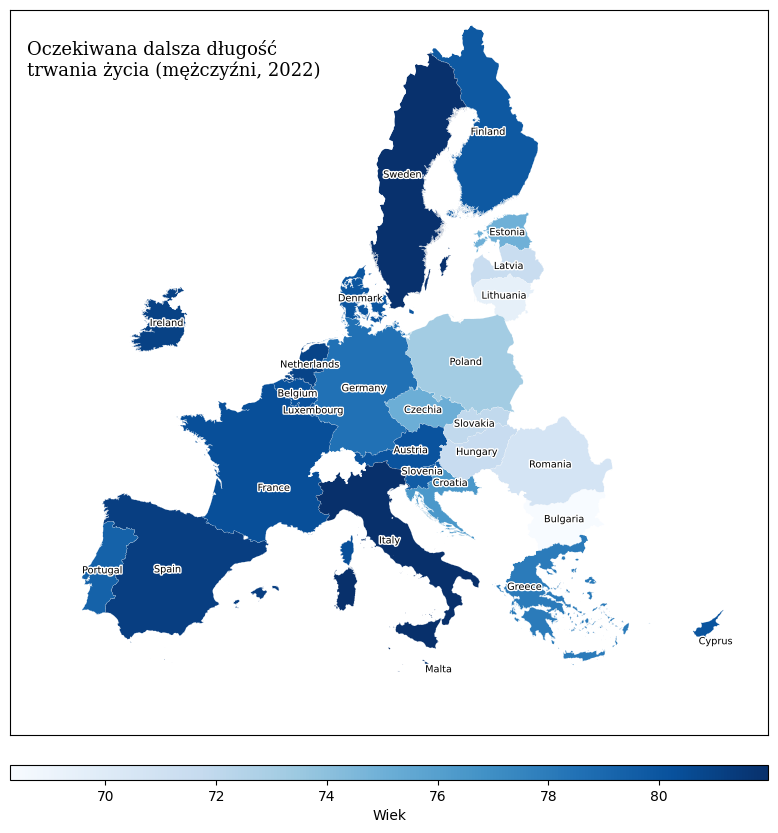

In [13]:
# Rysowanie mapy (mężczyźni)
plot_the_map('male', 'Blues')

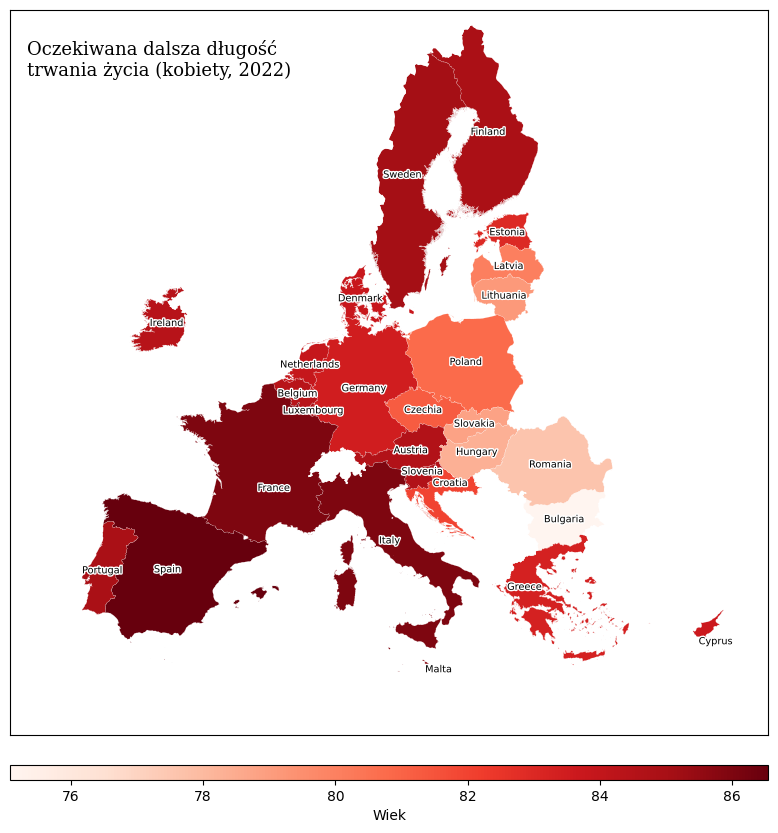

In [14]:
# # Rysowanie mapy (kobiety)
plot_the_map('female', 'Reds')

# **Infografika**

In [15]:
!mkdir infographics
import gdown
gdown.download("https://drive.google.com/file/d/19n2dg_w3qXDcZQ8VNaNspqPMeLSOgkbh/view?usp=sharing", "infographics/1.png", quiet=True, fuzzy=True)
gdown.download("https://drive.google.com/file/d/1iuH1XbaGV32hxw_12OtQ-U-jniN0eH6z/view?usp=sharing", "infographics/2.png", quiet=True, fuzzy=True)

'infographics/2.png'

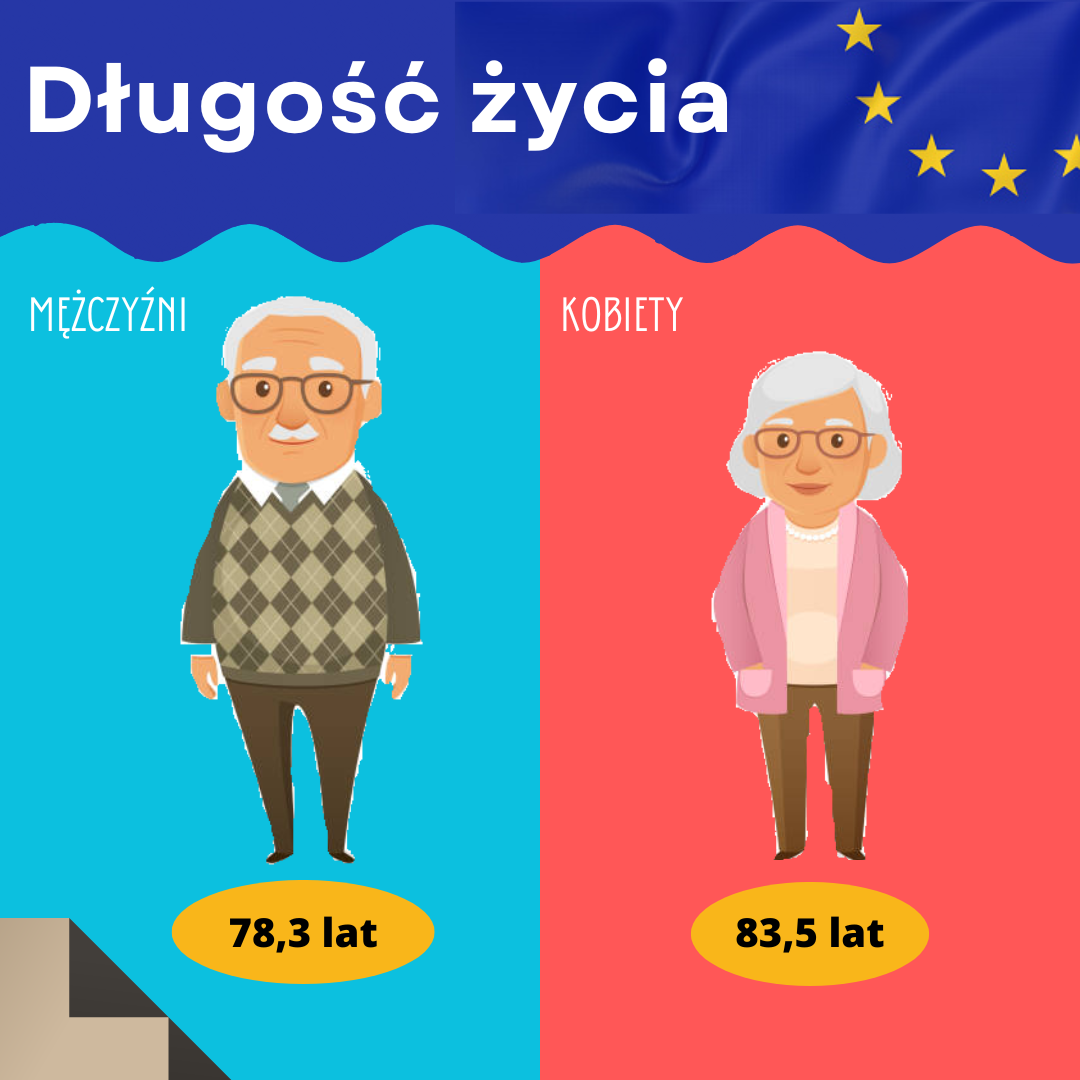

In [16]:
from IPython.display import Image, display
display(Image('infographics/1.png', width=500))

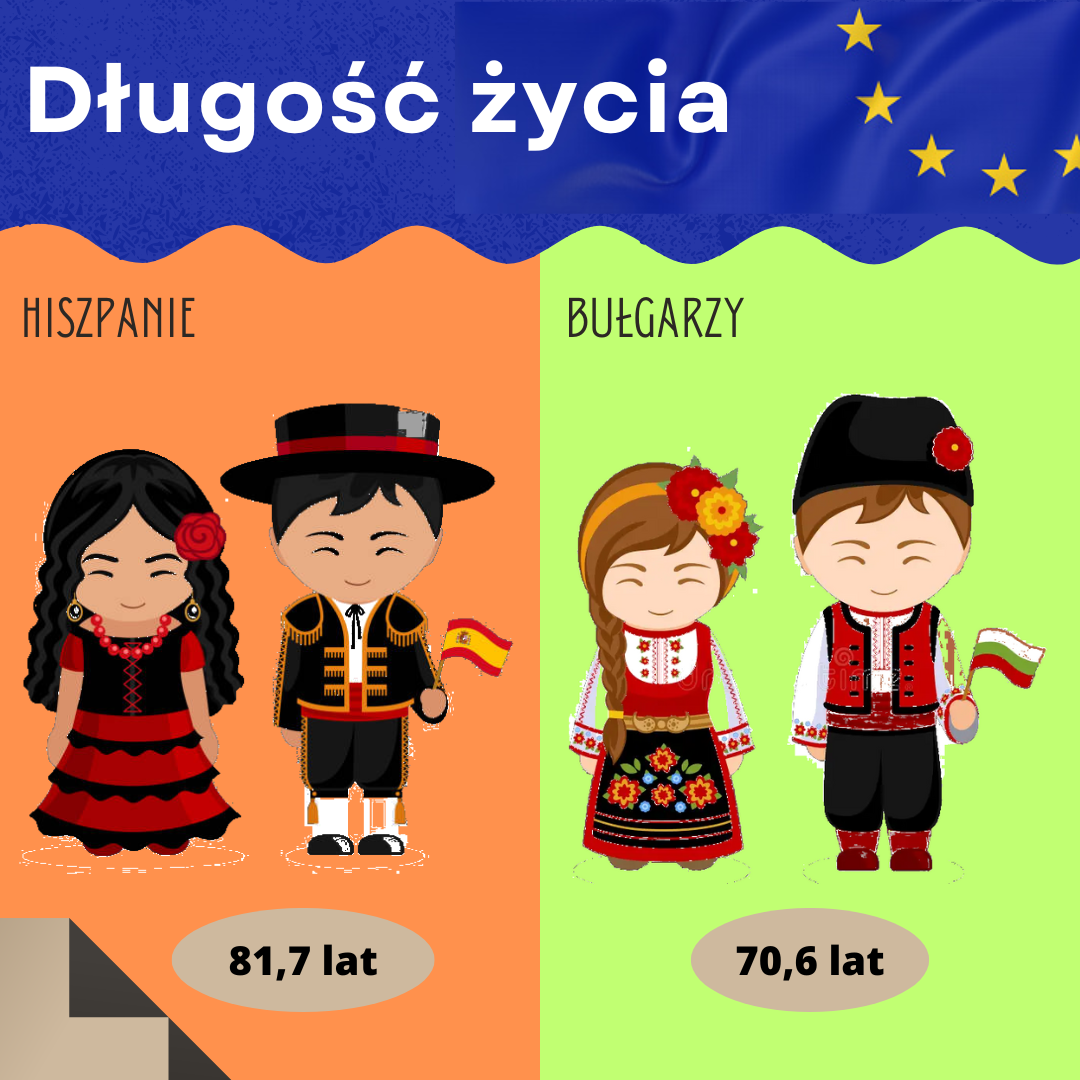

In [17]:
display(Image('infographics/2.png', width=500))